# Forecasting Philippine Trade Activity using local and global forecasting models: EDA

#### Borromeo, Castanares, Garcia, Tan

`"One of the job descriptions of a central banker is to be a time traveler. If [we] want to act, we want to know what will happen in the future so we can do something about it right now."
-Zeno Abenoja, BSP Deputy Governor`

## Abstract
Nowcasting models are an important tool that helps guide policy makers in recommending relevant, impactful and timely policies for the economy. Agencies such as the central banks continues to explore novel forecasting models to supportpolicy formulation. Philippine import/export is one of key economic indicator of interest to forecast as it is one of the components to the economic growth (GDP). Due to network effects of the supply chain and limited data sources of trade in the Philippines, developing an accurate model remains a challenge. Moreover, official trade statistics are published with a significant lag (two months) – making it challenging for policymakers to provide timely and data-driven policies.


In this study, we develop various forecasting models for Philippine Import and Export activity of the Philippines. We examine whether global forecasting models, with cross-learning, can able to provide better forecast performance compared local/single tasks models.

The study is broken down into three notebooks (by increasing concept complexity):

* 1_ExploratoryDataAnalysis
* 2_SingleTaskLearning
* 3_MultiTaskLearning



In [1]:
%%capture
!pip install xlrd
!pip install prophet
!pip install statsforecast
!pip install mlforecast
!pip install utilsforecast
!pip install tsfeatures
!pip install squarify

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
import os

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)

Mounted at /content/drive


## 1.0 The Dataset

The Exports and Import data was downloaded from S&P Global. In addition, we included Php to USD exchange rate monthly series.

In [3]:
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv', parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

print('Table. Export dataset')
display(DAT_Export)
display(DAT_Export.unique_id.unique())

Table. Export dataset


,ds,unique_id,y
0,2010-01-01,AUS,618.538
1,2010-02-01,AUS,613.971
2,2010-03-01,AUS,699.770
3,2010-04-01,AUS,769.386
4,2010-05-01,AUS,829.484
...,...,...,...
3289,2024-11-01,VNM,1886.123
3290,2024-12-01,VNM,1981.849
3291,2025-01-01,VNM,1843.337
3292,2025-02-01,VNM,1717.466


array(['AUS', 'CHN', 'HKG', 'IND', 'IDN', 'JPN', 'MYS', 'MMR', 'NZL',
       'PAK', 'PHL', 'QAT', 'SGP', 'KOR', 'TWN', 'THA', 'USA', 'VNM'],
      dtype=object)

In [4]:
DAT_Import = pd.read_csv(f'{DIR}/data/SPGlobal_Imports_clean.csv', parse_dates=['ds'])
DAT_Import.dropna(axis=0, inplace=True)
DAT_Import.drop(columns=['USA'], inplace=True)  # USA here is just dummy. No data provided by S&P
DAT_Import = DAT_Import.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

print('Table. Import dataset')
display(DAT_Import)
display(DAT_Import.unique_id.unique())

Table. Import dataset


,ds,unique_id,y
0,2010-01-01,AUS,681.955
1,2010-02-01,AUS,656.505
2,2010-03-01,AUS,772.444
3,2010-04-01,AUS,729.174
4,2010-05-01,AUS,720.774
...,...,...,...
3106,2024-11-01,VNM,1799.830
3107,2024-12-01,VNM,1911.778
3108,2025-01-01,VNM,1652.929
3109,2025-02-01,VNM,1763.304


array(['AUS', 'CHN', 'HKG', 'IND', 'IDN', 'JPN', 'MYS', 'MMR', 'NZL',
       'PAK', 'PHL', 'QAT', 'SGP', 'KOR', 'TWN', 'THA', 'VNM'],
      dtype=object)

In [8]:
df_FX = pd.read_excel(f'{DIR}/data/uscross_clean.xlsx',parse_dates=['Date'])[['Date','PHL']]
#rename column
df_FX = df_FX.rename(columns = {'Date':'ds'})
df_FX.set_index('ds', inplace=True)
df_FX = 1.0/df_FX
df_FX

,PHL
ds,
2010-01-01,46.028
2010-02-01,46.312
2010-03-01,45.742
2010-04-01,44.627
2010-05-01,45.597
...,...
2025-03-01,57.425
2025-04-01,56.853
2025-05-01,55.625


* The study utilizes two monthly datasets: DAT_Export and DAT_Import covering the period January 2010 to March 2025 (N_obs = 168 months).
* DAT_Export contains the monthly series of value of exported goods (in Billion USD) for different countries, e.g., USA and countries in ASEAN Region.
* DAT_Import contains the monthly series of imported goods (in Billion USD) for select countries.
* The US-PHP exchange rate series covers the period January 2010 to July 2025.


## 2.0 The Philippine Export and Import series

We investigate the characteristics of Ph Export and Import series.

<Axes: title={'center': 'Exchange Rate: PHP/1USD'}, xlabel='ds'>

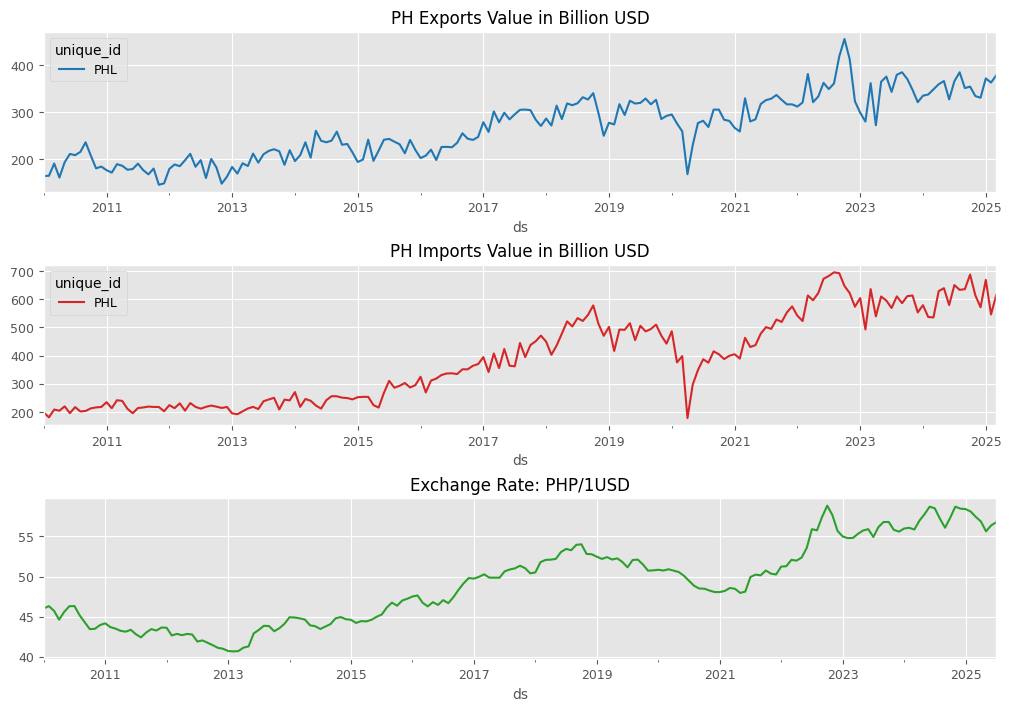

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
(DAT_Export.query('unique_id == "PHL"')
 .pivot_table(index='ds',
               columns='unique_id',
               values='y')
 .plot(ax=axs[0],
       color='tab:blue',
       title = 'PH Exports Value in Billion USD'))

(DAT_Import.query('unique_id == "PHL"')
 .pivot_table(index='ds',
               columns='unique_id',
               values='y')
 .plot(ax=axs[1],
       color='tab:red',
       title = 'PH Imports Value in Billion USD'))

(df_FX['PHL'].plot(ax=axs[2],
                   color='tab:green',
                   title = 'Exchange Rate: PHP/1USD'))

By visual inspection, we find the following:

* The Ph Import and Exports and strongly driven by trend
* The trend in the Import and Export series correlates with the trend in the exchange rate
* The troughs and peaks in the Import and Export series coincides (may relate) to economic events, e.g., Global Economic slowdown due to COVID-19 (2020) and resurgence of demand (2022).


## 3.0 TS Features of PH series

In [10]:
from tsfeatures import *

all_features = [
    acf_features,
    entropy,
    heterogeneity,
    nonlinearity,
    stl_features,
    stability,
    hurst,
]

#collect

df = pd.DataFrame([], index=DAT_Export.query('unique_id == "PHL"').set_index('ds').index)
df = df.assign(
    PHL_export = DAT_Export.query('unique_id == "PHL"').set_index('ds')['y'],
    PHL_import = DAT_Import.query('unique_id == "PHL"').set_index('ds')['y'],
    PHL_FX = df_FX['PHL'])

df = (df
      .reset_index()
      .melt(id_vars=['ds'], value_vars=['PHL_export', 'PHL_import', 'PHL_FX'])
      .rename(columns={'variable':'unique_id', 'value':'y'})
)

all_feat = tsfeatures(df, freq=12, features=all_features)
all_feat.set_index('unique_id').T.dropna(axis=0)

unique_id,PHL_FX,PHL_export,PHL_import
hurst,1.030e+00,1.053e+00,1.141e+00
stability,9.705e-01,8.946e-01,9.782e-01
nperiods,1.000e+00,1.000e+00,1.000e+00
seasonal_period,1.200e+01,1.200e+01,1.200e+01
trend,9.854e-01,9.288e-01,9.736e-01
spike,2.447e-08,6.229e-07,2.738e-07
linearity,1.212e+01,1.205e+01,1.247e+01
curvature,1.808e+00,2.223e-01,1.020e+00
e_acf1,6.319e-01,3.333e-01,1.825e-01
e_acf10,6.361e-01,3.017e-01,1.225e-01


Recall some of the key formulas:

STL decomposition equation:

\begin{align*}
    y_t &= S_t + T_t + R_t
\end{align*}

Strength of trend:
\begin{align*}
    F_T &= \text{max}\left( 0 , 1 - \frac{\text{Var}(R_t)}{\text{Var}(T_t + R_t)} \right)
\end{align*}

Strength of seasonality:
\begin{align*}
    F_S &= \text{max}\left( 0 , 1 - \frac{\text{Var}(R_t)}{\text{Var}(S_t + R_t)} \right)
\end{align*}

===
* All the series show a strong upward trend (see trend ~ 1.0)
* The is a considerable seasonal strength for Ph Export series (F_S = 0.461) which could reflect export agricultural goods that are tied to harvest seasons (e.g., coconut, bananas, pineapple and sugar).
* All three series have strong first autocorrelation (lag=1 month) with x_acf ~ 1.0
* The first autocorrelation can be reduced by taking the first difference of the series (evidenced by diff1_acf1 reduced to <0.3)
* While not visible in the previous plot, there is a degree of seasonality to all series indicated by seas_acf1 > 0.70.


## 4.0 STL Decomposition

#### STL of PH Export

,data,trend,seasonal,resid
ds,,,,
2010-01-01,164.515,196.934,-21.543,-10.877
2010-02-01,165.051,196.969,-25.142,-6.776
2010-03-01,191.054,196.921,-3.578,-2.288
2010-04-01,161.294,196.790,16.240,-51.736
2010-05-01,193.668,196.581,-3.302,0.389
...,...,...,...,...
2024-11-01,334.019,365.382,-22.117,-9.246
2024-12-01,330.503,367.017,-36.752,0.238
2025-01-01,371.471,368.688,-3.591,6.375


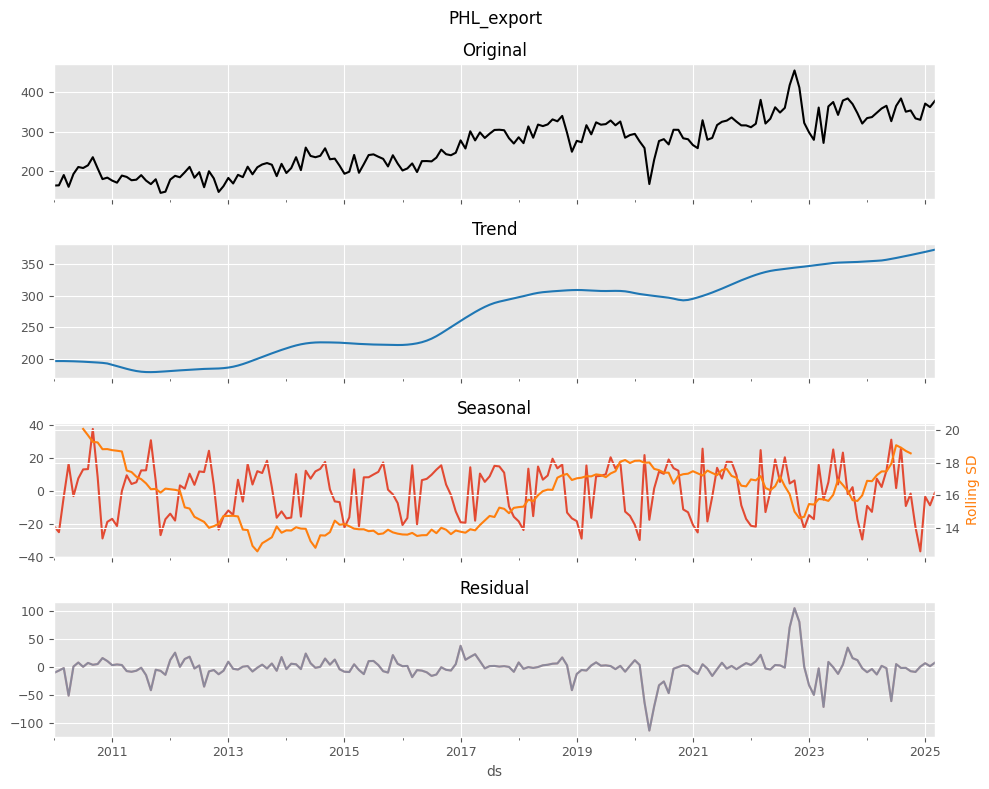

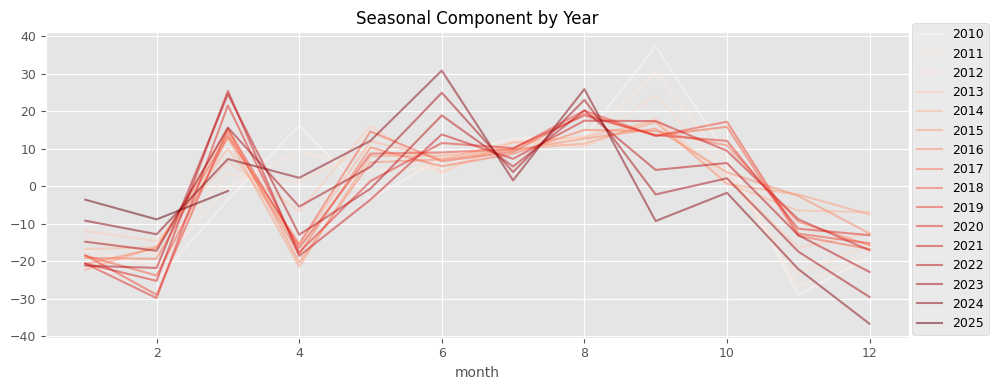

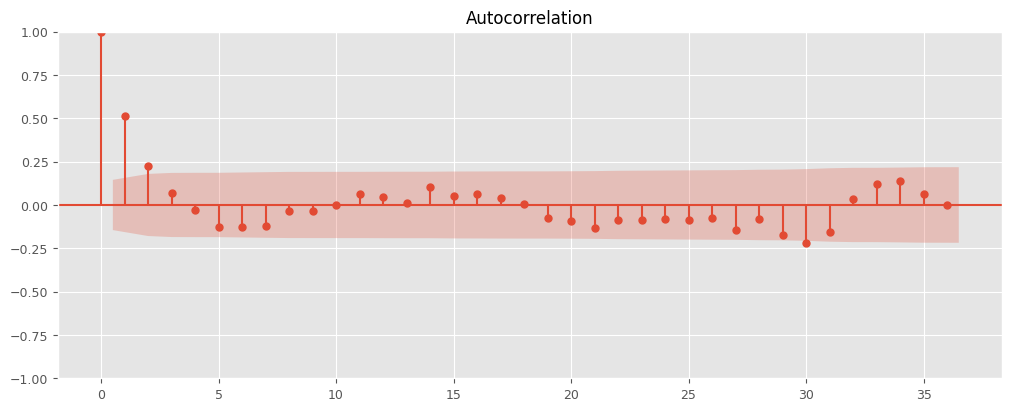

Shapiro-Wilk Test: statistic=0.771, p=0.000
Residuals do not appear to be normally distributed (reject H0)


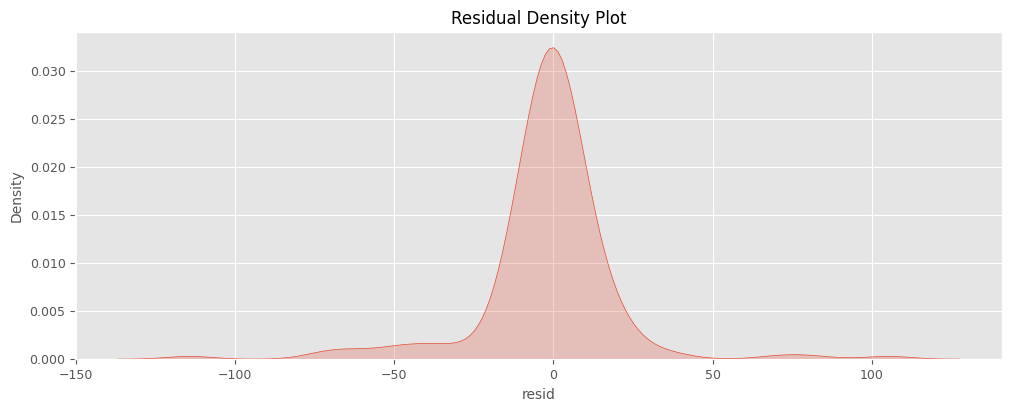

In [11]:
# STL decomposition
def stl_decomposition(var_data=[],
                      var_name='',
                      seasonal_period=12,
                      rolling_window=12):

    var_data = var_data.query('unique_id == @var_name').copy()
    stl_result = STL(var_data['y'], period=seasonal_period, robust=True).fit()

    # Prepare decomposition data
    decomp_data = pd.DataFrame({
        'ds': var_data["ds"].values,
        'data': var_data["y"].values,
        'trend': stl_result.trend,
        'seasonal': stl_result.seasonal,
        'resid': stl_result.resid
    }).set_index('ds')

    display(decomp_data)
    # Create plots

    fig, axes = plt.subplots(4, 1,
                            sharex=True,
                            figsize=(10, 8))

    # Plot components
    decomp_data['data'].plot(ax=axes[0],color='k')
    axes[0].set_title('Original')

    decomp_data['trend'].plot(ax=axes[1], color='tab:blue')
    axes[1].set_title('Trend')

    decomp_data['seasonal'].plot(ax=axes[2])
    axes[2].set_title('Seasonal')

    decomp_data['resid'].plot(ax=axes[3], alpha=0.6)
    decomp_data['resid'].plot(ax=axes[3], alpha=0.5)
    axes[3].set_title('Residual')

    # Add rolling variance to seasonal plot
    decomp_data['seasonal_sd'] = decomp_data['seasonal'].rolling(
        window=rolling_window, center=True
    ).std()

    ax2 = axes[2].twinx()
    decomp_data['seasonal_sd'].plot(ax=ax2, color='tab:orange')
    ax2.set_ylabel('Rolling SD', color='tab:orange')

    fig.suptitle(var_name, fontsize=12)
    plt.tight_layout()
    plt.show()

    return decomp_data

var_name = 'PHL_export'
decomp = stl_decomposition(var_data=df,
                    var_name=var_name,
                    seasonal_period=12,
                    rolling_window=12)

a = decomp[['seasonal']].copy()
a['month'] = a.index.month
a['year'] = a.index.year

a.pivot_table(index='month',
              columns='year',
              values='seasonal').plot(cmap='Reds',alpha=0.5)
plt.title('Seasonal Component by Year')
plt.legend(bbox_to_anchor=(1.1, 1.05), loc='upper right')
plt.autoscale()
plt.tight_layout()

plot_acf(decomp['resid'], lags=36);
plt.show()

fig, ax = plt.subplots()
sns.kdeplot(decomp['resid'], fill=True, ax = ax)
ax.set_title('Residual Density Plot')

#test whether residuals are white noise
from scipy.stats import shapiro
stat, p = shapiro(decomp['resid'].values)
print(f'Shapiro-Wilk Test: statistic={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Residuals appear to be normally distributed (fail to reject H0)')
else:
    print('Residuals do not appear to be normally distributed (reject H0)')

We used additive STL decomposition to analayze the trend,seasonal, and residuals of PH export.

* The trend of Ph Export show a long-term upward trend.
* The trend seems to level off every 5 years (2013-2017, 2017-2021).
* The Seasonal component show a mix of high frequency cycles.
* The amplitude of the seasonal components is observed to increase in the recent years.
* The Seasonal plot shows peak values at the month of March, July, August.
* Meanwhile, low export value is observed in the months of February, November, and December.
* The residuals are show strong auto-correlation at lags 1 and 2 months.
* The residuals are not normally distributed and exhibits long tails.

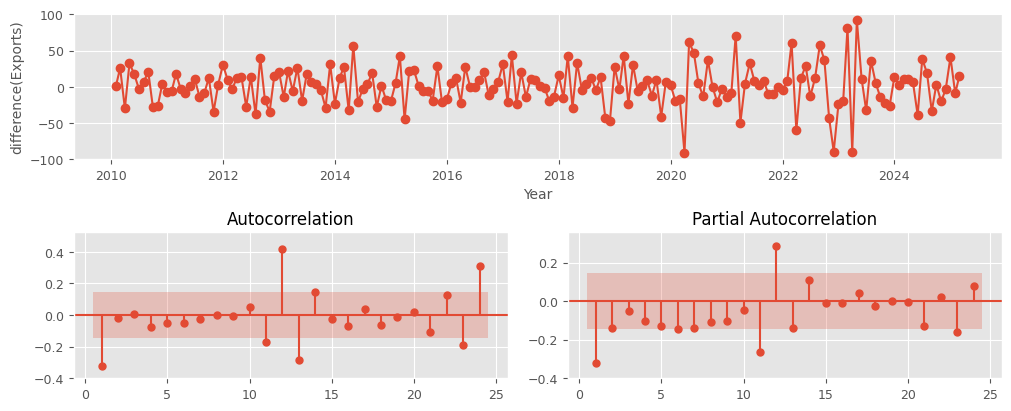

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

select='PHL_export'
df_in = df.query('unique_id == @select').copy().set_index('ds').drop('unique_id',axis=1)
df_in = df_in.diff(1).dropna()
fig = plt.figure()

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(df_in, marker="o")
ax1.set_ylabel("difference(Exports)")
ax1.set_xlabel("Year")

plot_acf(df_in, ax2, zero=False, lags=24,
         bartlett_confint=False,
         auto_ylims=True)
plot_pacf(df_in, ax3, zero=False, lags=24,
          auto_ylims=True)
plt.show()

*Note*:
The autocorrelation at the first lag can be removed via first differencing the series.

#### STL of PH Import

,data,trend,seasonal,resid
ds,,,,
2010-01-01,198.061,193.026,7.153,-2.119
2010-02-01,180.770,195.409,-9.542,-5.097
2010-03-01,208.423,197.743,16.479,-5.800
2010-04-01,204.187,200.027,6.647,-2.487
2010-05-01,219.704,202.259,12.420,5.024
...,...,...,...,...
2024-11-01,614.032,624.411,-6.614,-3.764
2024-12-01,571.665,625.773,-57.109,3.000
2025-01-01,668.765,627.119,38.657,2.988


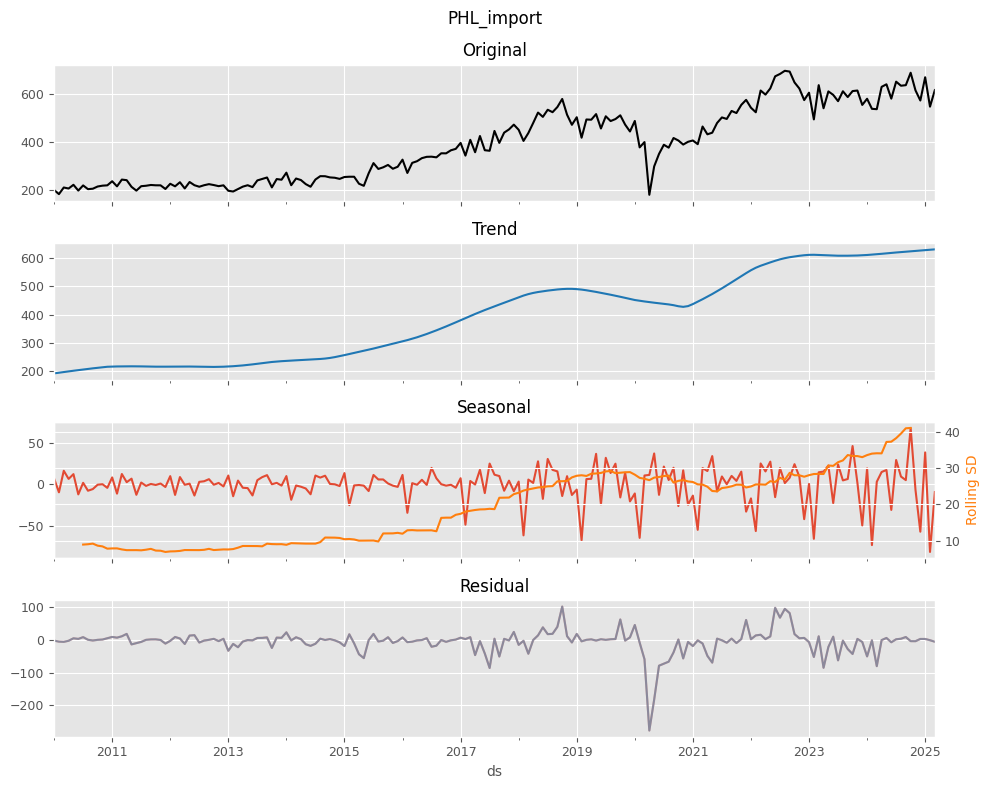

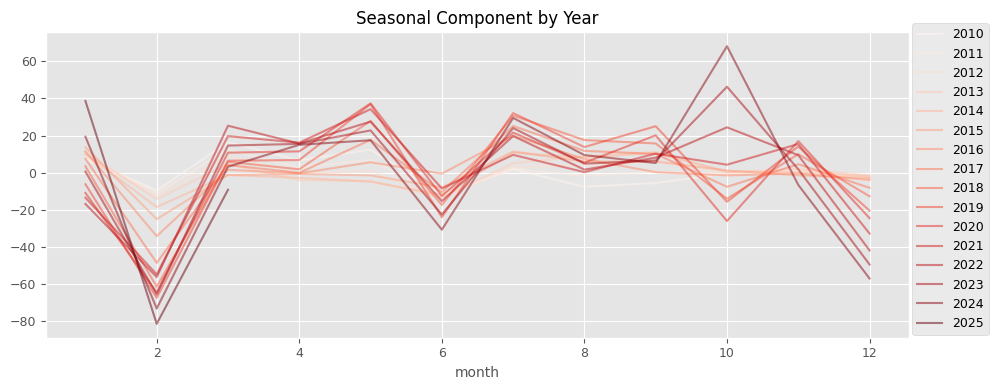

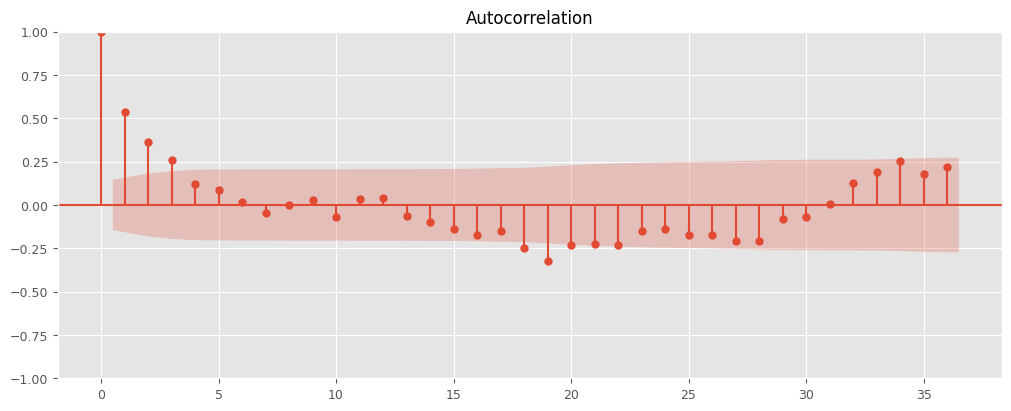

Shapiro-Wilk Test: statistic=0.713, p=0.000
Residuals do not appear to be normally distributed (reject H0)


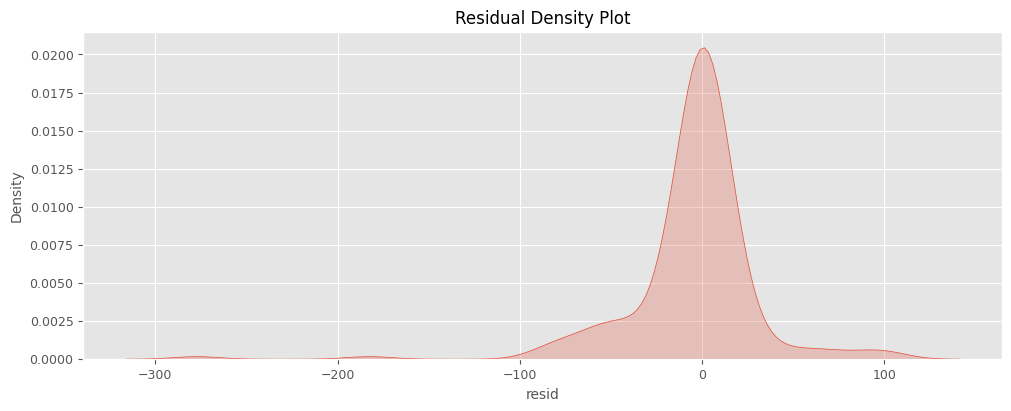

In [13]:
var_name = 'PHL_import'
decomp = stl_decomposition(var_data=df,
                    var_name=var_name,
                    seasonal_period=12,
                    rolling_window=12)

a = decomp[['seasonal']].copy()
a['month'] = a.index.month
a['year'] = a.index.year

a.pivot_table(index='month',
              columns='year',
              values='seasonal').plot(cmap='Reds',alpha=0.5)
plt.title('Seasonal Component by Year')
plt.legend(bbox_to_anchor=(1.1, 1.05), loc='upper right')
plt.autoscale()
plt.tight_layout()

plot_acf(decomp['resid'], lags=36);
plt.show()

fig, ax = plt.subplots()
sns.kdeplot(decomp['resid'], fill=True, ax = ax)
ax.set_title('Residual Density Plot')

#test whether residuals are white noise
stat, p = shapiro(decomp['resid'].values)
print(f'Shapiro-Wilk Test: statistic={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Residuals appear to be normally distributed (fail to reject H0)')
else:
    print('Residuals do not appear to be normally distributed (reject H0)')

For PH import.

* The trend of Ph Import show a long-term upward trend.
* The amplitude of the seasonal component increased starting in 2015 to 2025.
* There could be a relation between trend and seasonal component as the amplitude of the seasonality scales with the trend.
* The seasonal plot shows peak values at the month of October (in 2023-2024).
* Meanwhile, low import value is observed in the months of February and December.
* The residuals are also not normally distributed and exhibits significant auto-correlation with 1,2,3,18,and 19 month lags.

#### STL of PH-USD Exchange rate

,data,trend,seasonal,resid
ds,,,,
2010-01-01,46.028,46.205,0.037,-0.214
2010-02-01,46.312,46.010,0.122,0.180
2010-03-01,45.742,45.815,-0.068,-0.005
2010-04-01,44.627,45.620,-0.693,-0.300
2010-05-01,45.597,45.425,0.158,0.015
...,...,...,...,...
2024-11-01,58.695,58.327,0.099,0.268
2024-12-01,58.448,58.507,-0.351,0.292
2025-01-01,58.391,58.688,-0.332,0.035


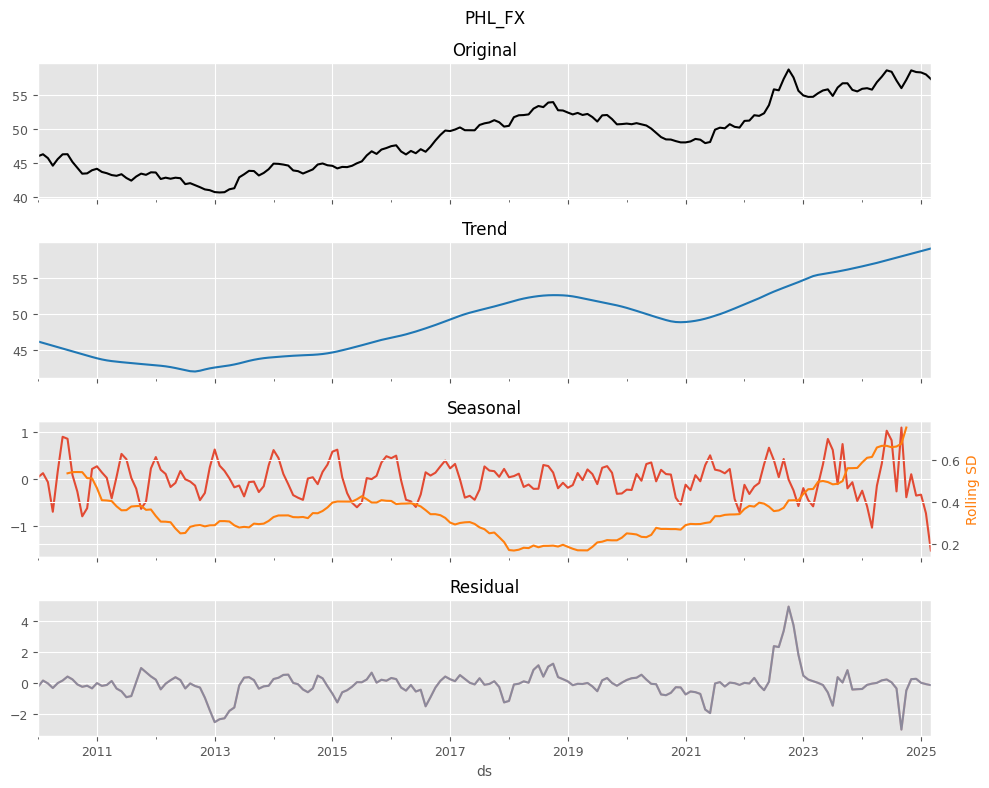

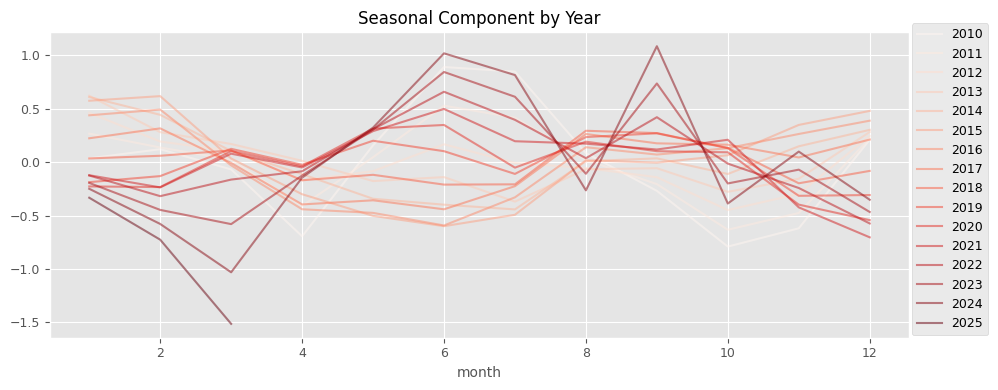

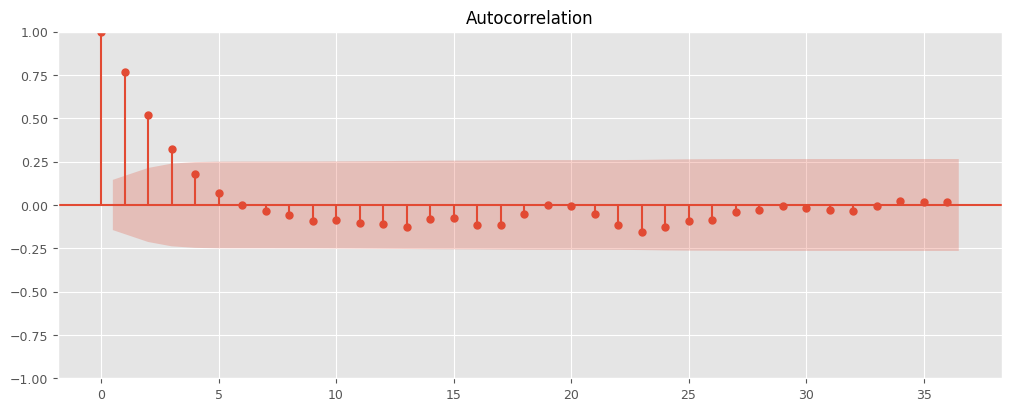

Shapiro-Wilk Test: statistic=0.807, p=0.000
Residuals do not appear to be normally distributed (reject H0)


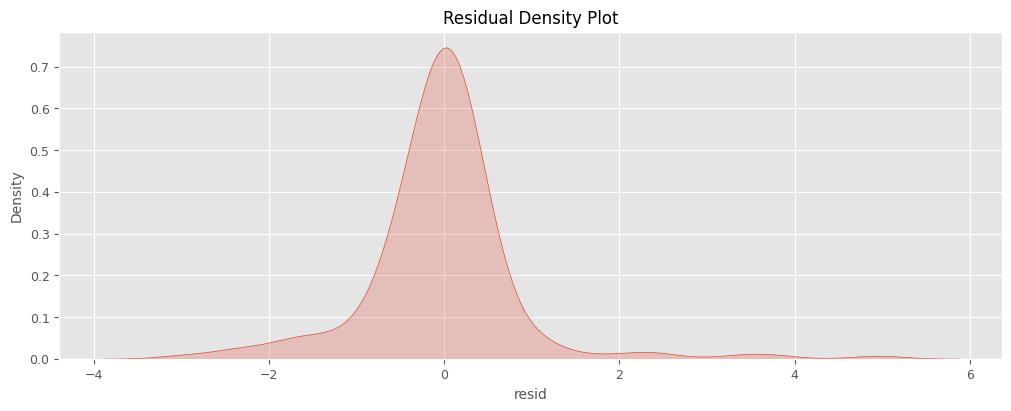

In [14]:
var_name = 'PHL_FX'
decomp = stl_decomposition(var_data=df,
                    var_name=var_name,
                    seasonal_period=12,
                    rolling_window=12)

a = decomp[['seasonal']].copy()
a['month'] = a.index.month
a['year'] = a.index.year

a.pivot_table(index='month',
              columns='year',
              values='seasonal').plot(cmap='Reds',alpha=0.5)
plt.title('Seasonal Component by Year')
plt.legend(bbox_to_anchor=(1.1, 1.05), loc='upper right')
plt.autoscale()
plt.tight_layout()

plot_acf(decomp['resid'], lags=36);
plt.show()

fig, ax = plt.subplots()
sns.kdeplot(decomp['resid'], fill=True, ax = ax)
ax.set_title('Residual Density Plot')

#test whether residuals are white noise
stat, p = shapiro(decomp['resid'].values)
print(f'Shapiro-Wilk Test: statistic={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Residuals appear to be normally distributed (fail to reject H0)')
else:
    print('Residuals do not appear to be normally distributed (reject H0)')

For PH FX.

* The trend of Ph FX show a long-term upward trend.
* The amplitude of the seasonal component decreased from 2011 to 2018
* however, the seasonal component of exchange rate started to increase 2023 onwards.
* The seasonal plot shows peak values at the month of June and September.
* The residuals are also not normally distributed (showing fat tails on either side) and exhibits significant auto-correlation with 1-3 lags.

## 5.0 Next Steps

1. Data Preprocessing:
* Apply first differencing to address high autocorrelation
* Consider log transformation to stabilize increasing seasonal variance
* Handle outliers from economic shocks (COVID-19 period)

2. Model Selection Strategy:
* Local Models (Single Task):
SARIMA models for capturing seasonal patterns and trends
Prophet for handling seasonal decomposition and holiday effects
Exponential Smoothing (Holt-Winters) for trend and seasonality

* Global Models (Multi Task):
Neural networks for cross-learning between Import/Export/FX of other countries
Global forecasting models with shared parameters across series

3. Feature Engineering:

* Include exchange rate as exogenous variable
* Add economic indicators and seasonal dummies
* Consider lagged variables and moving averages

4. Validation Strategy:
* Use time series cross-validation with expanding windows
* Reserve last 12-24 months for final testing
* Evaluate both point forecasts and prediction intervals

5. Hypothesis:
* We hypothesize that global models (Multi Task) can outperform local ones (Single Task) by leveraging cross-series information and common seasonal patterns.

## 6.0 Appendix

We analyzed features and correlation cross-country. For MTL, it is important that there is some degree of correlation across tasks.

In [15]:
#### Trends vs. Seasonality plot
all_features = [
    acf_features,
    entropy,
    heterogeneity,
    nonlinearity,
    stl_features,
    stability,
    hurst,
]

#collect

df = pd.read_csv(f'{DIR}/TRAIN.csv', parse_dates=['ds'])
tsfeatures_wide = tsfeatures(df, freq=12, features=all_features)
tsfeatures_wide['series'] = [x.split('_')[-1] for x in tsfeatures_wide['unique_id']]

In [16]:
import plotly.express as px
fig = px.scatter(tsfeatures_wide,
           x='trend',
           y='seasonal_strength',
           color='series',
           hover_data=['unique_id'])
fig.update_traces(marker=dict(size=12))

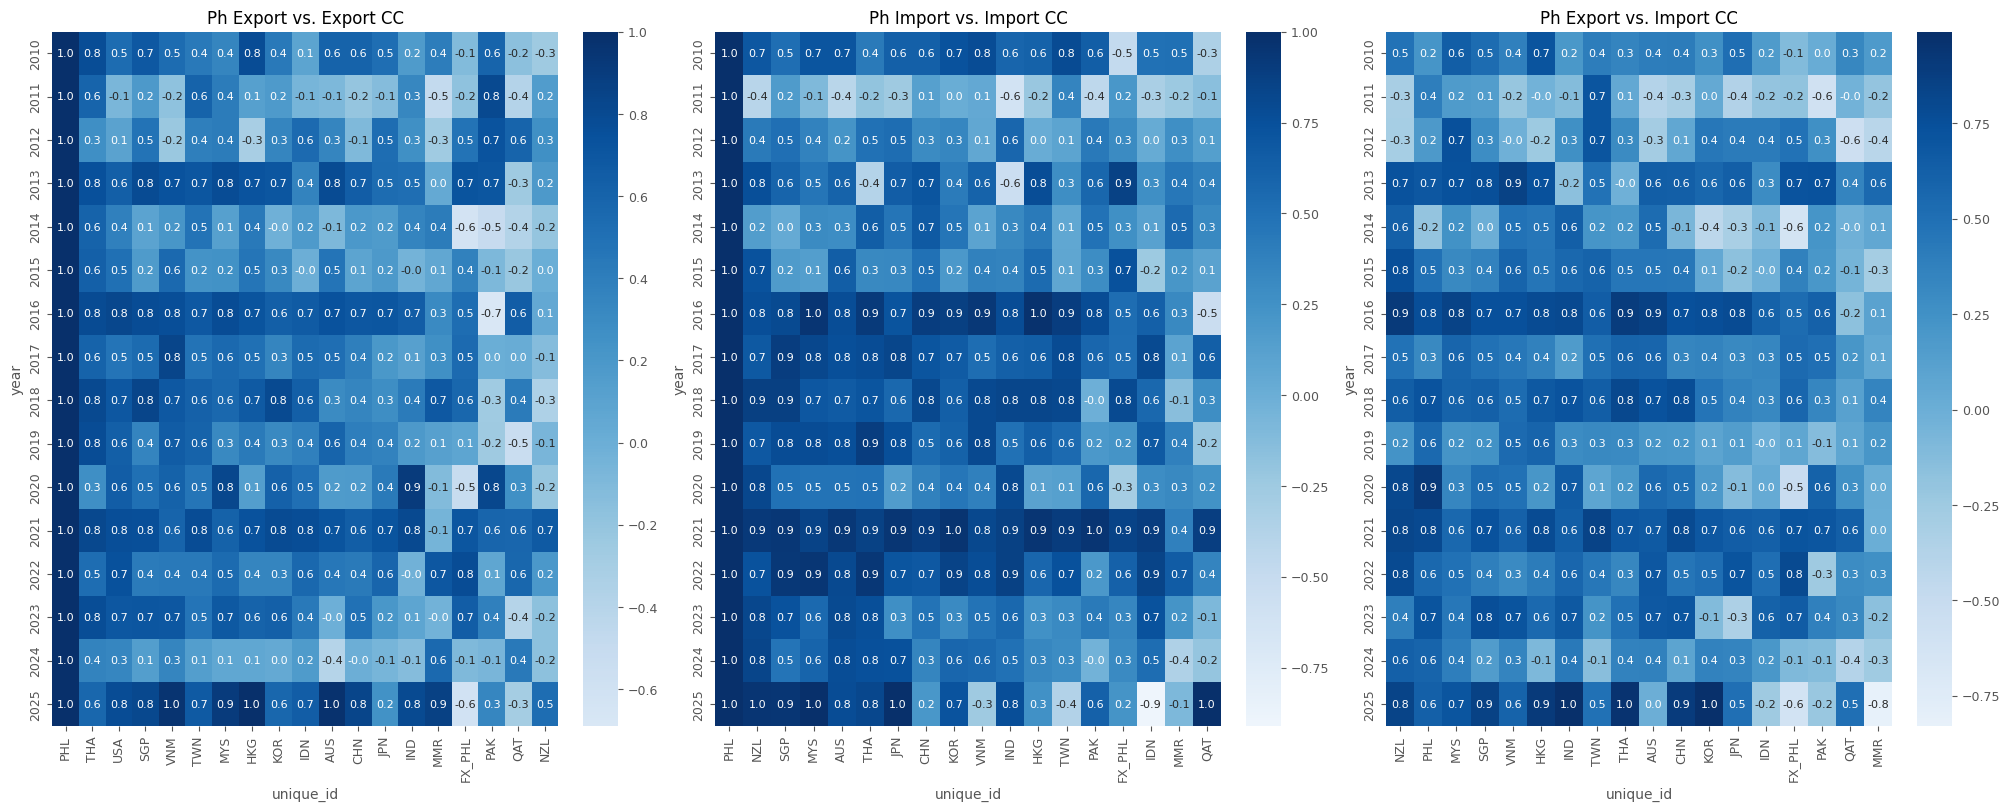

In [17]:
#### Correlation of the series for MTL
ref = DAT_Export.query('unique_id == "PHL"').set_index('ds').drop(columns=['unique_id'])
df = DAT_Export.pivot_table(index='ds', columns='unique_id', values='y')
df['FX_PHL'] = df_FX['PHL']

fig, axs = plt.subplots(1,3, figsize=(20,8))
axs = axs.flatten()

#correlation per year to detect co-movement
def plot_heatmap_corr(
            df_in = [],
            ref_in = [],
            axi = [],
            title = '',
    ):

    df = df_in.copy()
    ref = ref_in.copy()

    df['year'] = df.index.year
    df_corr = df.groupby('year').corrwith(ref['y'])
    df_corr.loc['all',:] = df_corr.sum(axis=0)

    #sort
    df_corr = df_corr.sort_values(by='all', ascending=False,axis=1)
    df_corr.drop(index='all', inplace=True)

    sns.heatmap(df_corr,
                annot=True,
                annot_kws={"size": 8,},
                cmap='Blues',
                fmt=".1f",
                center=0,
                ax=axi)
    axi.set_title(title)

ref = DAT_Export.query('unique_id == "PHL"').set_index('ds').drop(columns=['unique_id'])
df = DAT_Export.pivot_table(index='ds', columns='unique_id', values='y')
df['FX_PHL'] = df_FX['PHL']

plot_heatmap_corr(
        df_in = df,
        ref_in = ref,
        axi = axs[0],
        title='Ph Export vs. Export CC'
)

ref = DAT_Import.query('unique_id == "PHL"').set_index('ds').drop(columns=['unique_id'])
df = DAT_Import.pivot_table(index='ds', columns='unique_id', values='y')
df['FX_PHL'] = df_FX['PHL']

plot_heatmap_corr(
        df_in = df,
        ref_in = ref,
        axi = axs[1],
        title='Ph Import vs. Import CC'
)


ref = DAT_Export.query('unique_id == "PHL"').set_index('ds').drop(columns=['unique_id'])
df = DAT_Import.pivot_table(index='ds', columns='unique_id', values='y')
df['FX_PHL'] = df_FX['PHL']

plot_heatmap_corr(
        df_in = df,
        ref_in = ref,
        axi = axs[2],
        title='Ph Export vs. Import CC'

)



**Insight**:
* The plot of trend vs. seasonal strength show that there is a strong trend of import/export activity of countries in the dataset.
* Also the correlation of PH import/activity against other countries are relatively high (>0.5) for Ph export to export series; Ph import to import series.
* The correlation is high with trade partners (USA, Singapore, HongKong, China) and is to be robust across years.
* This indicates that there is a shared correlated information/feature between trade partners of PH that can be utilized in the MTL.